# Determine stacking sequence for a panel

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from geneticalgorithm import geneticalgorithm as ga

## Example Data

In [2]:
ncells = 9
nlayers = 21

MIN_ANGLE_COUNT = np.array(
     [[4, 4, 2, 2],
      [2, 2, 2, 2],
      [3, 2, 2, 2],
      [3, 2, 2, 4],
      [5, 5, 4, 4],
      [3, 4, 2, 2],
      [4, 4, 4, 4],
      [4, 4, 4, 4],
      [3, 4, 2, 2]], dtype=int)

adjacent = np.array([1, 2, 2, 3, 1, 4, 2, 5, 3, 6, 4, 5, 5, 6, 4, 7, 5, 8, 6, 9, 7, 8, 8, 9], 
                    dtype=int).reshape((-1, 2))
adjacent -= 1 # adjust to 0 based indexing


## Version 1: orientation defined per cell

In [7]:
# x: stacking sequence for one cell.
# each cell has a stacking sequence, of predefined length nlayers
# range 0..4; where 0 denotes empty

def plycount_per_orientation(x):
    return np.array([np.sum(x == i) for i in range(1, 4+1)], dtype=int)

def plycount(x):
    return np.count_nonzero(x)

#1. for each pair of adjacent cells c1 and c2 with MinPlyCount n1 and n2, 
#   min(n1, n2) layers have to be continuous. Ply k is continuous if 
#   besetzt[c1, k] /\ besetzt[c2, k].
def neighbor_violations(x1, x2):
    # set of (ply_index, angle_index) pairs
    s1 = set((i, a) for i, a in enumerate(x1) if a>0)
    s2 = set((i, a) for i, a in enumerate(x2) if a>0)
    return len(s1 & s2) >= min(len(s1), len(s2))
    
#2. Symmetric  
def symmetry_violations(x):
    xc = x[x>0]
    n = len(xc)
    return sum(xc[i] != xc[n-1-i] for i in range(n//2))

#3. Balanced
def balanced_violations(x):
    return abs(np.sum(x == 3) - np.sum(x == 4))

#4. min 10% in any direction
def min_ratio_violations(x, ratio):
    xc = x[x>0]
    n = len(xc)
    return sum(np.sum(xc==i) >= n*ratio for i in range(1, 4+1))

#5. Max nc consecutive plies of same orientation
def contiguous_violations(x, ncmax):
    xc = x[x>0]
    n = len(xc)
    failed = 0
    for i in range(n-ncmax-1):
        s = set(xc[i:i+1+ncmax])
        if len(s) > 1:
            failed += 1
    return failed
    
# vereinfachte version -> verheiratet 6 und 7
#6. outer plies are +/- 45
#7. outer plies are continuous, i.e. active in each cell
def outer_ply_violations(x):
    return sum([x[0] != 3, x[1] != 4, x[-2] != 4, x[-1] != 3])

#8. for each cell, and each orientation: actual counts per orientation >= MinPlyCount
def min_ply_violations(x, mincount):
    return sum(plycount_per_orientation(x) < mincount)

def implies(a, b):
    return (not a) or (a and b)

#9. +/- always together
def plusminus_violations(x):
    xc = x[x>0]
    nc = len(xc)
    failed = 0
    for i in range(1, nc-1):
        before, p, after = xc[i-1:i+2]
        if not (implies(p==3, 4 in (before, after)) and implies(p==4, 3 in (before, after))):
            failed += 1
    return failed

In [8]:
# accelerated penalty function
def local_violations(seq, mincount, ncmax):
    # symmetry
    n = len(seq)
    n_sym = sum(seq[i] != seq[-1-i] for i in range(n//2))
    # per orientation
    plycount_per_orientation = np.array([np.sum(seq == i) for i in range(1, 4+1)], dtype=int)

def neighbor_penalty():
    pass

In [39]:
x = np.random.randint(1, 4+1, 10)
x

array([2, 3, 3, 3, 3, 2, 2, 3, 4, 3])

In [41]:
x.

<ipython-input-41-c63ea0b99c14>:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  x == np.arange(1,4+1)


False

## objective function

In [17]:
MINRATIO = 0.1
MAXCONT = 2
RHO_PEN = 10

# simple representation: angle define dper layer and cell
def f(x):
    xm = x.reshape((ncells, nlayers)) 
    
    # compute volume
    objective = 0
    for c in range(ncells):
        objective += plycount(xm[c])
    
    # compute constraint violations
    pcount = 0
    
    # single cell
    for c in range(ncells):
        xc = xm[c]
        
        pcount += symmetry_violations(xc)
        pcount += balanced_violations(xc)
        pcount += min_ratio_violations(xc, MINRATIO)
        pcount += contiguous_violations(xc, MAXCONT)
        pcount += outer_ply_violations(xc)
        pcount += min_ply_violations(xc, MIN_ANGLE_COUNT[c])
        pcount += plusminus_violations(xc)

        #pcount += symmetry_violations(xc) > 0
        #pcount += balanced_violations(xc) > 0
        #pcount += min_ratio_violations(xc, MINRATIO) > 0
        #pcount += contiguous_violations(xc, MAXCONT) > 0
        #pcount += outer_ply_violations(xc) > 0
        #pcount += min_ply_violations(xc, MIN_ANGLE_COUNT[c]) > 0
        #pcount += plusminus_violations(xc) > 0

        
    # adjacent cells
    for c1, c2 in adjacent:
        xc1 = xm[c1]
        xc2 = xm[c2]
        pcount += neighbor_violations(xc1, xc2)
        #pcount += neighbor_violations(xc1, xc2) > 0
            
    # penalised objective value
    return objective + 2*(pcount>0)*MIN_ANGLE_COUNT.sum() + RHO_PEN*pcount**2

def pointer_to_simple(xp):
    orient = xp[:nlayers].reshape((1, nlayers))
    active = xp[nlayers:].reshape((ncells, nlayers))
    # convert to simple
    return orient*active    

# pointer representation, as in minizinc
def f2(xp):
    return f(pointer_to_simple(xp))
    

## Example

In [30]:
# lowest value we can get
print(MIN_ANGLE_COUNT.sum())

# create random vectors
x1 = np.random.randint(0, 4+1, ncells*nlayers)
print(x1.reshape((ncells, nlayers)))

# compute function
print('mpv', min_ply_violations(x1, MIN_ANGLE_COUNT[4]))
print(f(x1))

# pointer representation
orient = np.random.randint(1, 4+1, nlayers)
active = np.random.randint(0, 1+1, ncells*nlayers) #.reshape((ncells, nlayers))
print(orient)
print(active.reshape(ncells, nlayers))
xp = np.concatenate([orient, active])
print(pointer_to_simple(xp))

112
[[3 1 4 0 1 0 2 3 3 3 4 2 3 1 2 3 4 3 1 2 0]
 [4 1 4 4 4 0 3 2 1 3 3 4 1 3 3 4 0 2 0 3 1]
 [2 0 2 2 4 0 4 4 3 2 3 0 2 4 0 1 1 2 1 4 4]
 [0 1 1 4 2 2 1 2 2 3 1 0 3 3 1 1 1 4 3 1 4]
 [4 3 1 4 2 4 4 1 4 4 2 0 2 3 0 3 0 4 2 3 4]
 [3 1 1 1 4 3 1 4 4 0 4 4 1 2 1 0 0 2 1 1 0]
 [4 3 1 2 1 4 0 0 0 4 3 1 0 2 1 4 0 4 3 3 0]
 [1 2 4 4 4 3 3 3 4 3 4 4 4 3 0 2 1 2 4 2 1]
 [3 0 2 1 0 1 3 1 4 1 1 2 0 1 1 4 1 4 3 4 3]]
mpv 0
936744
[1 4 1 3 2 4 4 4 1 1 2 1 2 3 3 3 4 4 2 1 1]
[[0 0 0 1 0 1 0 1 0 0 1 1 1 0 1 0 0 0 1 1 1]
 [0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 1 0]
 [0 0 1 0 0 0 1 1 1 0 0 1 1 1 0 1 0 1 0 1 1]
 [0 1 0 0 0 0 0 0 1 1 0 1 1 0 0 0 1 1 1 1 0]
 [0 0 1 1 0 1 1 0 0 0 0 0 1 1 0 0 0 1 0 1 0]
 [1 0 1 0 1 1 1 1 1 0 0 0 1 1 0 1 1 1 1 0 0]
 [0 0 0 1 0 0 0 1 0 1 0 1 1 0 0 1 0 1 1 0 0]
 [0 0 1 0 0 0 0 0 0 1 0 1 0 1 0 0 1 0 0 0 1]
 [0 0 1 1 0 0 1 0 0 0 1 0 0 1 1 0 1 0 0 0 1]]
[[0 0 0 3 0 4 0 4 0 0 2 1 2 0 3 0 0 0 2 1 1]
 [0 0 1 0 0 4 0 0 0 0 0 1 0 0 0 0 0 4 0 1 0]
 [0 0 1 0 0 0 4 4 1 0 0 1 2 3 0 3 0 4

## optimise

In [46]:
# simple representation
varbound_simple = np.array([(0, 4)]*ncells*nlayers)

# pointer representation
varbound_pointers = np.array([(1,4)]*nlayers + [(0,1)]*ncells*nlayers)

algorithm_param = {'max_num_iteration': 1000,
                   'population_size': 100,
                   'mutation_probability': 0.3,
                   'elit_ratio': 0.02,
                   'crossover_probability': 0.5,
                   'parents_portion': 0.3,
                   'crossover_type': 'uniform', #'two_point', #'one_point', 
                   'max_iteration_without_improv': None}

model=ga(function=f2, 
         #dimension=ncells*nlayers, 
         dimension=nlayers + ncells*nlayers,
         variable_type='int', 
         #variable_boundaries=varbound_simple,
         variable_boundaries=varbound_pointers,
         algorithm_parameters=algorithm_param)

 The best solution found:                                                                           
 [1. 1. 1. 1. 1. 1. 1. 1. 2. 1. 4. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 1.
 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 1. 0.
 0. 1. 0. 1. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0.
 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 1. 0. 0. 0.
 0. 1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1.]

 Objective function:
 52120.0


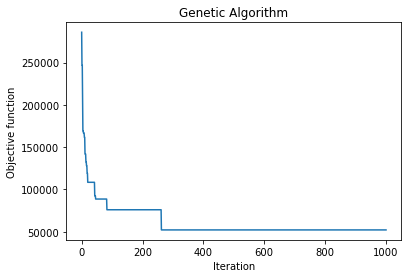

In [47]:
model.run()